## Simpsons characters classification 

In this notebook we try to classify images of different simpsons characters. The characters are 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner' and 'sideshow_bob'.
This dataset was preprocessed in an other notebook, it is splitted into a train val and testset and resized into 80x80 pixels and all characters have more than 600 images in total. The whole dataset with the original size can be found here https://www.kaggle.com/alexattia/the-simpsons-characters-dataset. 

#### Imports

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import os

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical


In [0]:
os.getcwd()


'/content/drive/My Drive'

In [0]:
Data=pd.read_csv("Data.csv")

X_train=np.load("X_train.npy")
Y_train=np.load("Y_train.npy")

X_val=np.load("X_val.npy")
Y_val=np.load("Y_val.npy")

X_test=np.load("X_test.npy")
Y_test=np.load("Y_test.npy")

labels=Data["label"].unique()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(9637, 80, 80, 3)
(4131, 80, 80, 3)
(3442, 80, 80, 3)
(9637, 14)
(4131, 14)
(3442, 14)


Let's use the trainset to plot a random image of each character. You can see that the characters are easy recognizable. And all images are the same size.

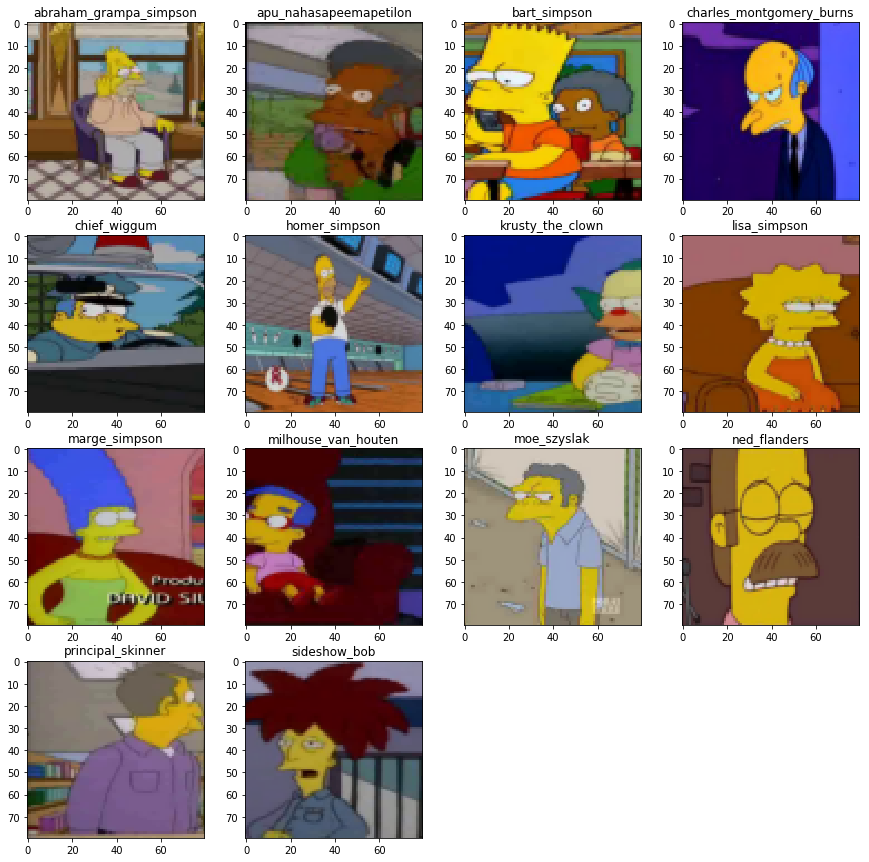

In [0]:
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(4,4,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])

In this cell we plot the label distribution of all sets. You clearly see that the label distribution in all sets is very similar. The biggest class in the trainigset is obviously homer and the smallest class is apu.

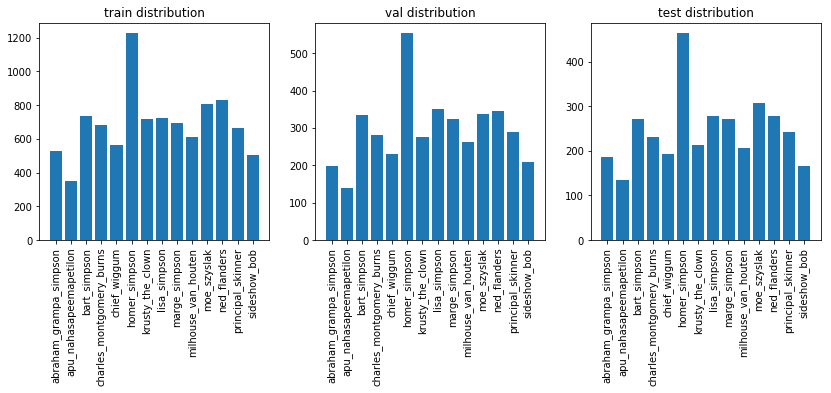

In [0]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.bar(np.unique(np.argmax(Y_train,axis=1),return_counts=True)[0],np.unique(np.argmax(Y_train,axis=1),return_counts=True)[1]
       ,tick_label=labels )
plt.xticks(rotation=90)
plt.title("train distribution")
plt.subplot(1,3,2)
plt.bar(np.unique(np.argmax(Y_val,axis=1),return_counts=True)[0],np.unique(np.argmax(Y_val,axis=1),return_counts=True)[1]
       ,tick_label=labels )
plt.xticks(rotation=90)
plt.title("val distribution")
plt.subplot(1,3,3)
plt.bar(np.unique(np.argmax(Y_test,axis=1),return_counts=True)[0],np.unique(np.argmax(Y_test,axis=1),return_counts=True)[1]
       ,tick_label=labels )
plt.xticks(rotation=90)
plt.title("test distribution")
plt.show()

### Random guessing

Let's build our first "classifier", what would be the accuracy if we would just random guess one of the labels for all testimages. Note that here, every character has the same chance to be predicted.


In [0]:
random_pred=np.zeros((len(X_test)),dtype="int64")
for i in range (0,len(X_test)):
    random_pred[i]=np.random.choice(np.arange(0,max(np.argmax(Y_test,axis=1)+1)),1)
acc=np.average(random_pred==np.argmax(Y_test,axis=1))
res1 = pd.DataFrame(
          {'Acc' : acc}, index=['random_guessing']
)
res1

,Acc
random_guessing,0.070017


### Weighted random guessing

Now let's build an other classifier, instead of just random guessing we now want to use the class distribution of the trainset, this means the chances that we predict homer are higher than that we predict apu and so on. Note that we assume that the testset is the same as the training here which is not always the case.


In [0]:
class_probs=np.unique(np.argmax(Y_train,axis=1),return_counts=True)[1]/len(Y_train)
weighted_random_pred=np.zeros((len(X_test)),dtype="int64")
for i in range (0,len(X_test)):
    weighted_random_pred[i]=np.random.choice(np.arange(0,max(np.argmax(Y_test,axis=1)+1)),1,p=class_probs)
acc= np.average(weighted_random_pred==np.argmax(Y_test,axis=1))
res2 = pd.DataFrame(
          {'Acc' : acc}, index=['weighted_random_guessing']
)
pd.concat([res1,res2])


,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666


### All max class

The next "classifier", is just predicting every image to the biggest class, in our case this is homer. What is the accuracy if we just predict "homer" for all test images.

In [0]:
idx=np.where(np.unique(np.argmax(Y_train,axis=1),return_counts=True)[1]==max(np.unique(np.argmax(Y_train,axis=1),return_counts=True)[1]))
max_class=np.unique(np.argmax(Y_train,axis=1),return_counts=True)[0][idx]
#print(max_class)
acc=np.average(max_class==np.argmax(Y_test,axis=1))
res3 = pd.DataFrame(
          {'Acc' : acc}, index=['all_max_class']
)
pd.concat([res1,res2,res3])


,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805


### RF with HOG features

Let's use the fist real classifier. In the next cells we extract the histograms of oriented gradients of every 20x20 pxiel patch (the parameter orientations is the number of histograms you want to extract from each patch, and the pixel_per_cell parameter defines how big a patch is). Then we use a random forest model and train it on the hog featues of the the training data and use the trained model to predict the class of the images based on the hog features of the testdata. Finally we calculate the accuracy on the testset.

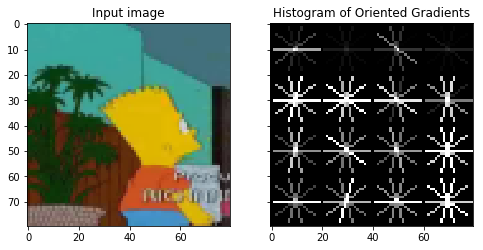

In [0]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(X_train[0], orientations=5, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.imshow(X_train[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [0]:
hog_features_train=np.zeros((len(X_train),fd.shape[0]))
for i in tqdm(range(0,len(X_train))):
  fd, hog_image = hog(X_train[i], orientations=5, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
  hog_features_train[i]=fd
  
hog_features_test=np.zeros((len(X_test),fd.shape[0]))
for i in tqdm(range(0,len(X_test))):
  fd, hog_image = hog(X_test[i], orientations=5, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
  hog_features_test[i]=fd

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,random_state=22)
clf.fit(hog_features_train, np.argmax(Y_train,axis=1))  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [0]:
pred=clf.predict(hog_features_test)
acc=np.average(pred==np.argmax(Y_test,axis=1))
res4 = pd.DataFrame(
          {'Acc' : acc}, index=['RF_with_hog']
)
pd.concat([res1,res2,res3,res4])

,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805
RF_with_hog,0.366066


### RF with colorhist featues

In the next cells we extract the colorhistogram of each colorchannel. We choose a binsize of 12 and just extract 12 numbers for each channel, with 3 channels, we have 36 features per image. We again use a random forest model and train it on the colorhistogram-features of the the training data and use the trained model to predict the class of the images based on the colorhistogram-features of the testdata. Finally we calculate the accuracy on the testset.

In [0]:
bin_size=12

col_hist_train=np.zeros((len(X_train),3*bin_size))
for i in tqdm(range(0,len(X_train))):
    col_hist_1=np.histogram(X_train[i,:,:,0],range=[0,255],bins=bin_size)[0]
    col_hist_2=np.histogram(X_train[i,:,:,1],range=[0,255],bins=bin_size)[0]
    col_hist_3=np.histogram(X_train[i,:,:,2],range=[0,255],bins=bin_size)[0]
    col_hist_train[i]=np.concatenate([col_hist_1,col_hist_2,col_hist_3])

col_hist_test=np.zeros((len(X_test),3*bin_size))
for i in tqdm(range(0,len(X_test))):
    col_hist_1=np.histogram(X_test[i,:,:,0],range=[0,255],bins=bin_size)[0]
    col_hist_2=np.histogram(X_test[i,:,:,1],range=[0,255],bins=bin_size)[0]
    col_hist_3=np.histogram(X_test[i,:,:,2],range=[0,255],bins=bin_size)[0]
    col_hist_test[i]=np.concatenate([col_hist_1,col_hist_2,col_hist_3])


In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,random_state=22)
clf.fit(col_hist_train, np.argmax(Y_train,axis=1))  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [0]:
pred=clf.predict(col_hist_test)
acc=np.average(pred==np.argmax(Y_test,axis=1))
res5 = pd.DataFrame(
          {'Acc' : acc}, index=['RF_with_colhist']
)
pd.concat([res1,res2,res3,res4,res5])

,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805
RF_with_hog,0.366066
RF_with_colhist,0.614468


### Fully connected neural network

In the next cells we want to use a fully connected neural network. For this we first normalize the pixelvalues to be in the range from -1 to 1. Then we need to flatten the imput, note that we ignoire the 2d structure of the image here. We use a neural network with two hidden layers with the nodesizes of 800 and 200 and use the relu non-linearity. Finally we predict the probabilities for the 14 character with the softmax activation. As loss function we use the categorical crossentropy. We use a batchsize of 64 and fit for 5 epochs. We use the trainset to learn the weights and validate our performance on the validationset. For an estimation of the performace on new unseen data we predict the testset and check the performance.

In [0]:
X_train=np.array(X_train,dtype="float32")
X_train=((X_train/255)-0.5)*2

X_val=np.array(X_val,dtype="float32")
X_val=((X_val/255)-0.5)*2

X_test=np.array(X_test,dtype="float32")
X_test=((X_test/255)-0.5)*2

In [0]:

model  =  Sequential()

model.add(Flatten(input_shape=(80,80,3)))
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(14))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 800)               15360800  
_________________________________________________________________
activation_9 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               160200    
_________________________________________________________________
activation_10 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 14)                2814      
_________________________________________________________________
activation_11 (Activation)   (None, 14)               

In [0]:
model.fit(X_train, Y_train, 
                  batch_size=64, 
                  epochs=5,
                  verbose=2,
                  shuffle=True,
                  validation_data=(X_val, Y_val))

Train on 9637 samples, validate on 4131 samples
Epoch 1/5
9637/9637 - 3s - loss: 2.9557 - acc: 0.3218 - val_loss: 1.9324 - val_acc: 0.4055
Epoch 2/5
9637/9637 - 2s - loss: 1.6210 - acc: 0.4962 - val_loss: 1.7806 - val_acc: 0.4570
Epoch 3/5
9637/9637 - 2s - loss: 1.3065 - acc: 0.5982 - val_loss: 1.7914 - val_acc: 0.4754
Epoch 4/5
9637/9637 - 2s - loss: 1.0646 - acc: 0.6648 - val_loss: 1.7619 - val_acc: 0.5064
Epoch 5/5
9637/9637 - 2s - loss: 0.8349 - acc: 0.7386 - val_loss: 1.8294 - val_acc: 0.5202


In [0]:
acc=np.average(model.predict_classes(X_test)==np.argmax(Y_test,axis=1))
res6 = pd.DataFrame({'Acc' : acc}, index=['FCN_on_pixel'])
pd.concat([res1,res2,res3,res4,res5,res6])

,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805
RF_with_hog,0.366066
RF_with_colhist,0.614468
FCN_on_pixel,0.509878


### VGG feature extraction and RF 

Now we will use a neural network (VGG16) that was trainend on Imagenet and we will only use the convolutional part to extract featues for our simpson images. With the features we will train and random forest classifier. Note that this network is trained to classify animals, vehicles and plants and was trained on a very large dataset. Let's see if we can extract useful features to decide which simpson character is on the image.

In [0]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(80,80,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [0]:
#X_train_vgg_features=base_model.predict(X_train)
#X_val_vgg_features=base_model.predict(X_val)
#X_test_vgg_features=base_model.predict(X_test)

#X_train_vgg_features=X_train_vgg_features.reshape((len(X_train),512*2*2))
#X_val_vgg_features=X_val_vgg_features.reshape((len(X_val),512*2*2))
#X_test_vgg_features=X_test_vgg_features.reshape((len(X_test),512*2*2))

#takes a lot of time

# load results
X_train_vgg_features=np.load("X_train_vgg_features.npy")
X_val_vgg_features=np.load("X_val_vgg_features.npy")
X_test_vgg_features=np.load("X_test_vgg_features.npy")


In [0]:
clf = RandomForestClassifier(n_estimators=100,random_state=22)
clf.fit(X_train_vgg_features, np.argmax(Y_train,axis=1))  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [0]:
pred=clf.predict(X_test_vgg_features)
acc=np.average(pred==np.argmax(Y_test,axis=1))
res7 = pd.DataFrame(
          {'Acc' : acc}, index=['RF_on_vgg_features']
)
pd.concat([res1,res2,res3,res4,res5,res6,res7])

,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805
RF_with_hog,0.366066
RF_with_colhist,0.614468
FCN_on_pixel,0.509878
RF_on_vgg_features,0.608077


### Tranfer learning after VGG extraction (only if you use colab)

In this section we will again use a neural network (VGG16) that was trainend on Imagenet and this time we will add two fully connected layer on top of the features extraction part. We will freeze the weights of the convolutional part and only train the fully connected part that we added. We will predict the probabilities for the 14 character with the softmax activation. As loss function we use the categorical crossentropy. We use a batchsize of 64 and fit for 5 epochs. We use the trainset to learn the weights and validate our performance on the validationset. For an estimation of the performace on new unseen data we predict the testset and check the performance. Note that the training of the network may take a lot of time if you run it on your local machine.

In [0]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(80,80,3))

In [0]:
x = base_model.output
x = Flatten()(x)

x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)


predictions = Dense(max(Data["Klasse"])+1, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
for i, layer in enumerate(model.layers):
   print(i, layer.name,layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten_5 True
20 dense_15 True
21 dense_16 True
22 dense_17 True


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0   

In [0]:
model.fit(X_train, Y_train, 
                  batch_size=64, 
                  epochs=5,
                  verbose=2,
                  shuffle=True,
                  validation_data=(X_val, Y_val))

Train on 9637 samples, validate on 4131 samples
Epoch 1/5
9637/9637 - 21s - loss: 1.5855 - acc: 0.5026 - val_loss: 1.1443 - val_acc: 0.6526
Epoch 2/5
9637/9637 - 20s - loss: 0.9090 - acc: 0.7205 - val_loss: 1.0623 - val_acc: 0.6737
Epoch 3/5
9637/9637 - 20s - loss: 0.6488 - acc: 0.8011 - val_loss: 1.0103 - val_acc: 0.6977
Epoch 4/5
9637/9637 - 20s - loss: 0.4626 - acc: 0.8598 - val_loss: 1.0346 - val_acc: 0.7006
Epoch 5/5
9637/9637 - 20s - loss: 0.3068 - acc: 0.9093 - val_loss: 1.0985 - val_acc: 0.7037


In [0]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res8 = pd.DataFrame(
          {'Acc' : acc}, index=['transfer_learning_on_vgg_features']
)
pd.concat([res1,res2,res3,res4,res5,res6,res7,res8])

,Acc
random_guessing,0.070017
weighted_random_guessing,0.074666
all_max_class,0.134805
RF_with_hog,0.366066
RF_with_colhist,0.614468
FCN_on_pixel,0.509878
RF_on_vgg_features,0.608077
transfer_learning_on_vgg_features,0.710343


### Now it's your turn



*   Take the best model and check the indvudial class performace for each class.
*   Look at some wrong predictions.
*   Try to improve the performace on the testset with a different model.  
*   *Hints:  You may want to use a deeper neutal network, or combine the features for the random forest. Maybe data augmntation could improve the performace or a CNN form scratch may work well.*




In [0]:
### acc per class
pred=np.argmax(model.predict(X_test),axis=1)
for i in range(0,len(labels)):
  print(labels[i],np.average(pred[np.where(np.argmax(Y_test,axis=1)==i)]==i))

abraham_grampa_simpson 0.6505376344086021
apu_nahasapeemapetilon 0.8074074074074075
bart_simpson 0.6875
charles_montgomery_burns 0.6320346320346321
chief_wiggum 0.7979274611398963
homer_simpson 0.7176724137931034
krusty_the_clown 0.6948356807511737
lisa_simpson 0.5806451612903226
marge_simpson 0.7195571955719557
milhouse_van_houten 0.7718446601941747
moe_szyslak 0.6013071895424836
ned_flanders 0.7706093189964157
principal_skinner 0.7925311203319502
sideshow_bob 0.8493975903614458


predicted: ['chief_wiggum']
true: ['charles_montgomery_burns']


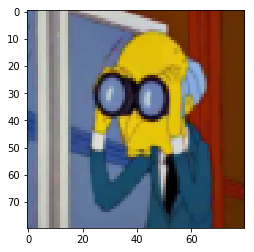

In [0]:
X_test_unnorm=np.load("X_test.npy")
idx=np.where(pred!=np.argmax(Y_test,axis=1))[0]
rmd=np.random.choice(idx,1)
print("predicted:",labels[pred[rmd]])
print("true:",labels[np.argmax(Y_test,axis=1)[rmd]])
plt.imshow(np.squeeze(X_test_unnorm[rmd]))
plt.show()